# Inference

In [1]:
import init

In [2]:
import os
import json
import torch
import argparse
import numpy as np

from models.model_pos import POSVAE
from utils import idx2word, interpolate, AttributeDict
from models.model_utils import to_var, to_tensor
from tqdm._tqdm_notebook import tqdm_notebook

In [3]:
def load_json(path):
    with open(path, 'r') as file:
        return json.load(file)

In [4]:
import pandas as pd
pd.set_option("display.max_colwidth", 500) # 1セルに500文字入る
pd.set_option("display.max_rows", 100) # 100行表示できる

In [5]:
top_dir = os.path.abspath('..')
runs_dir = f'{top_dir}/runs'
data_base_dir = f'{top_dir}/data'
data_name = 'eccos_v2'
data_dir = f'{data_base_dir}/{data_name}'
print(f'top_dir: {top_dir}\nruns_dir: {runs_dir}\ndata_dir: {data_dir}')

top_dir: /root/user/work/src/Sentence-VAE
runs_dir: /root/user/work/src/Sentence-VAE/runs
data_dir: /root/user/work/src/Sentence-VAE/data/eccos_v2


In [6]:
model_name = 'posvae_eccos_v2_TS=2020-01-05-173701_BS=32_LR=0.001_EB=300_GRU_HS=256_L=1_BI=0_LS=16_WD=0_ANN=LOGISTIC_K=0.0025_X0=2500'
model_path = f'{runs_dir}/{model_name}/models/model_E9.pytorch'
model_meta_path = f'{runs_dir}/{model_name}/models/model_meta.json'

In [7]:
args = load_json(model_meta_path)
args = AttributeDict(args)
args.rnn_type = args.rnn_type.lower()
assert args.rnn_type in ['rnn', 'lstm', 'gru']
assert 0 <= args.word_dropout <= 1

## load vocab

In [8]:
data_types = ['src', 'tgt', 'pos']

In [9]:
from collections import namedtuple
Vocab = namedtuple('Vocab' , 'w2i i2w')
VocabSet = namedtuple('VocabSet' , 'text pos')

In [10]:
vocab_dict = {key: Vocab(**load_json(f'{data_dir}/{data_type}/ptb.vocab.json')) for key, data_type in zip(['text', 'pos'], ['src', 'pos'])}
vocab = VocabSet(**vocab_dict)

In [11]:
# src と tgt で vocab が同じか
assert load_json(f'{data_dir}/src/ptb.vocab.json') == load_json(f'{data_dir}/tgt/ptb.vocab.json')

## load model

In [12]:
from constant import SOS_INDEX, EOS_INDEX, PAD_INDEX, UNK_INDEX

In [13]:
# _dict = torch.load(model_path)
# model_shapes = {k: v.shape for k,v in _dict.items()}
# model_shapes

In [14]:
def load_model(path):
    _dict = torch.load(path)
    model_shapes = {k: v.shape for k,v in _dict.items()}
    ext_kwargs = {}
        
    # Latent size
    latent_size = model_shapes.get('hidden2logv.bias')[0]
    print(f'Latent size: {latent_size}')
        
    model = POSVAE(
        vocab_size=len(vocab.text.w2i),
        pos_vocab_size=len(vocab.pos.w2i),
        embedding_size=args.embedding_size,
        pos_embedding_size=args.pos_embedding_size,
        rnn_type=args.rnn_type,
        hidden_size=args.hidden_size,
        word_dropout=args.word_dropout,
        embedding_dropout=args.embedding_dropout,
        latent_size=latent_size,
        tgt_max_sequence_length=args.tgt_max_sequence_length,
        pos_max_sequence_length=args.pos_max_sequence_length,
        num_layers=args.num_layers,
        bidirectional=args.bidirectional,        
        **ext_kwargs,
    )
    print(model)
    
    if not os.path.exists(path):
        raise FileNotFoundError(path)

    model.load_state_dict(torch.load(path))
    print("Model loaded from %s"%(path))

    if torch.cuda.is_available():
        model = model.cuda()
        
    model.eval()
    return model

In [15]:
model = load_model(model_path)

Latent size: 16
POSVAE(
  (embedding): Embedding(10293, 300)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (pos_embedding): Embedding(16, 20)
  (encoder_rnn): GRU(300, 256, batch_first=True)
  (pos_decoder_rnn): GRU(20, 256, batch_first=True)
  (hidden2mean): Linear(in_features=256, out_features=16, bias=True)
  (hidden2logv): Linear(in_features=256, out_features=16, bias=True)
  (latent2pos_decoder_hidden): Linear(in_features=16, out_features=256, bias=True)
  (outputs2pos): Linear(in_features=256, out_features=16, bias=True)
  (pos_encoder_rnn): GRU(20, 256, batch_first=True)
  (text_decoder_rnn): GRU(300, 256, batch_first=True)
  (latent2pos_encoder_hidden): Linear(in_features=16, out_features=256, bias=True)
  (outputs2vocab): Linear(in_features=256, out_features=10293, bias=True)
)
Model loaded from /root/user/work/src/Sentence-VAE/runs/posvae_eccos_v2_TS=2020-01-05-173701_BS=32_LR=0.001_EB=300_GRU_HS=256_L=1_BI=0_LS=16_WD=0_ANN=LOGISTIC_K=0.0025_X0=2500/models/model_E9.p

## sample 指定 inference

### load test data

In [16]:
from ptb import PTB
def load_test_ptb(path):
    return PTB(
        data_dir=path,
        split='test',
        create_data=False,
    )

In [17]:
PTBSet = namedtuple('PTBSet' , 'src tgt pos')

In [18]:
ptbs = PTBSet(**{key: load_test_ptb(f'{data_dir}/{key}/') for key in 'src tgt pos'.split(' ')})

In [19]:
from utils import ids2text

In [20]:
def _sample_data(index, ptb):
    sample = ptb.data[f'{index}']
    sample_input = to_tensor(sample['input']).view(1,-1).to(dtype=torch.int64)
    sample_length = to_tensor([sample['length']]).to(dtype=torch.int64)
    return {'input': sample_input, 'length': sample_length}

In [21]:
Sequence = namedtuple('Sequence', 'input length')
Sample = namedtuple('Sample' , 'src tgt pos')

In [22]:
def sample_data(index, ptbs, show=False):
    src_sample = Sequence(**_sample_data(index, ptbs.src))
    tgt_sample = Sequence(**_sample_data(index, ptbs.tgt))
    pos_sample = Sequence(**_sample_data(index, ptbs.pos))
    sample = Sample(src=src_sample, tgt=tgt_sample, pos=pos_sample)
    if show:
        print(f'▼ Input length:{sample.src.length.item()}\n{ids2text(sample.src.input.squeeze(), vocab.text.i2w)}')
        print(f'▼ POS length:{sample.pos.length.item()}\n{ids2text(sample.pos.input.squeeze(), vocab.pos.i2w, sep=",")}')
    return sample

In [23]:
# データをピックアップ, 確認
sample = sample_data(241, ptbs, show=True)

▼ Input length:14
毎朝のヒゲ剃り時間が激的に軽減される!?
▼ POS length:13
名詞,助詞,名詞,名詞,助詞,名詞,名詞,助詞,名詞,動詞,動詞,記号


### sampling

In [24]:
def encode_z(model, sample):
    # z を得るまで
    with torch.no_grad():
        text_hidden = model.text_encode(sample.src.input, sample.src.length)
        mean, logv, z = model.hidden2latent(text_hidden)
    return {
        'mean': mean,
        'logv': logv,
        'z': z,
    }

In [25]:
# torch.distributions.normal.Normal(1, 2).sample((1,))

In [47]:
from metric import remove_pad_index

In [54]:
def encode_print_samples(model, sample, n=30, pos_list=None, show=True):
    # n回サンプリング
    args.num_samples = n
    encoded_z = encode_z(model, sample)
    mean, std = encoded_z['mean'].squeeze(), torch.exp(0.5 * encoded_z['logv']).squeeze()
    z_dist = torch.distributions.normal.Normal(mean, std)
    z_list = z_dist.sample((n,))
    
    if pos_list is None:
        pos_decoded_ids = model.pos_inference(z=z_list) # z → POS
    else:
        # POS固定パターン
        pos_decoded_ids = to_tensor([vocab.pos.w2i[pos] for pos in pos_list] + [EOS_INDEX], ).to(dtype=torch.int64)
        # 各サンプル用に複製
        pos_decoded_ids = pos_decoded_ids.repeat(n, 1)
    
    pos_decoded_input, pos_decoded_length = model.target2input(pos_decoded_ids)  # POS → POS Input
    text_decoded_ids = model.text_inference(pos_decoded_input, pos_decoded_length, z_list) # POS Input → Text
        
    decoded_texts = [ids2text(_ids.squeeze(), vocab.text.i2w) for _ids in text_decoded_ids]
    decoded_poses = [ids2text(_ids.squeeze(), vocab.pos.i2w, sep=',') for _ids in pos_decoded_ids]
    
    input_text = ids2text(sample.src.input.squeeze(), vocab.text.i2w)
    input_pos = ids2text(sample.pos.input.squeeze(), vocab.pos.i2w, sep=',')
    if show:
        print('■ 入力')
        print(input_text)
        print('■ 入力POS')
        print(input_pos)
        print(f'■ {args.num_samples}件 サンプリング')
    return {
        'input_text': input_text,
        'input_pos': input_pos,
        'df': pd.DataFrame({'生成文': decoded_texts, '生成POS': decoded_poses, 
                            '生成文_ids': remove_pad_index(text_decoded_ids.tolist()), 
                            '生成POS_ids': remove_pad_index(pos_decoded_ids.tolist())}),
        **encoded_z
    }

In [27]:
# 存在チェック
# df = decode_dict['df']
# print(decode_dict['input_pos'])
# df[df['生成POS'] == decode_dict['input_pos']]

In [121]:
# pos_list = None
# pos_list = '副詞,名詞,名詞,名詞'.split(',')
# pos_list = '記号,名詞,名詞,記号,名詞'.split(',')
pos_list = '記号,接頭詞,名詞,助詞,名詞,記号,助詞,動詞,副詞,名詞,名詞,名詞,助詞,動詞,助詞,動詞,助動詞'.split(',')

In [123]:
sample = sample_data(4, ptbs)
decode_dict = encode_print_samples(model, sample, n=10, pos_list=pos_list)
decode_dict['df']['生成文'] = decode_dict['df']['生成文'].apply(lambda x: x.replace('<sep>', ''))
# decode_dict['df']['生成文'].to_frame()
decode_dict['df'][['生成文', '生成POS']]

■ 入力
お肌が劇的に変わる♡プルプル日中美容クリームを使ってみた
■ 入力POS
接頭詞,名詞,助詞,名詞,助詞,動詞,記号,副詞,名詞,名詞,名詞,助詞,動詞,助詞,動詞,助動詞
■ 10件 サンプリング


,生成文,生成POS
0,「お肌の塗り替え」<num>歳主婦が若見えする秘密とは,"記号,接頭詞,名詞,助詞,名詞,記号,助詞,動詞,副詞,名詞,名詞,名詞,助詞,動詞,助詞,動詞,助動詞"
1,「お肌に自信あり」保湿力を使ってみたらお肌に,"記号,接頭詞,名詞,助詞,名詞,記号,助詞,動詞,副詞,名詞,名詞,名詞,助詞,動詞,助詞,動詞,助動詞"
2,「お肌の塗り替え」<num>歳主婦が若見えする秘密とは,"記号,接頭詞,名詞,助詞,名詞,記号,助詞,動詞,副詞,名詞,名詞,名詞,助詞,動詞,助詞,動詞,助動詞"
3,「お肌の調子」を整え続けるその方法知っていた,"記号,接頭詞,名詞,助詞,名詞,記号,助詞,動詞,副詞,名詞,名詞,名詞,助詞,動詞,助詞,動詞,助動詞"
4,「お肌に自信あり」塗るだけで毛穴レス肌になる方法が凄かった,"記号,接頭詞,名詞,助詞,名詞,記号,助詞,動詞,副詞,名詞,名詞,名詞,助詞,動詞,助詞,動詞,助動詞"
5,【お肌を保護】あの人気タレントも愛用するクレンジングを使ってみた,"記号,接頭詞,名詞,助詞,名詞,記号,助詞,動詞,副詞,名詞,名詞,名詞,助詞,動詞,助詞,動詞,助動詞"
6,「お肌の塗り替え」<num>歳主婦が試してみたお肌に,"記号,接頭詞,名詞,助詞,名詞,記号,助詞,動詞,副詞,名詞,名詞,名詞,助詞,動詞,助詞,動詞,助動詞"
7,「お肌の調子」を整え続けるお肌に優しいオイルとは,"記号,接頭詞,名詞,助詞,名詞,記号,助詞,動詞,副詞,名詞,名詞,名詞,助詞,動詞,助詞,動詞,助動詞"
8,「お肌に自信持てる」お風呂上がりに使ってみたら毛穴汚れがドバッ!,"記号,接頭詞,名詞,助詞,名詞,記号,助詞,動詞,副詞,名詞,名詞,名詞,助詞,動詞,助詞,動詞,助動詞"
9,「お肌の救世主」が超使える保湿力とは,"記号,接頭詞,名詞,助詞,名詞,記号,助詞,動詞,副詞,名詞,名詞,名詞,助詞,動詞,助詞,動詞,助動詞"


#### 評価用データ吐き出し

In [37]:
# サンプルid指定する場合
# sample_num = 50
# sample_ids = torch.randint(len(ptbs.src), (sample_num,)).tolist()
# sample_ids = [208, 1324, 2018, 323, 1955, 1750, 1294, 1204, 1907, 210, 1473, 576, 802, 814, 421, 772, 1168, 1719, 841, 163, 14, 53, 97, 159, 1197, 459, 1675, 1031, 2298, 1906, 336, 1649, 2077, 1129, 2316, 2382, 499, 2071, 1949, 261, 1875, 951, 1482, 77, 2036, 2034, 849, 631, 1730, 1576]
# テストデータ全体の場合
sample_ids = range(len(ptbs.src))

In [61]:
decode_num = 10

In [68]:
def list2dict(key, _list):
    return {f'{key}{i}': decoded_text for i, decoded_text in enumerate(_list)}

In [74]:
%%time
total_decoded_list = []
for sample_id in sample_ids:
    if sample_id % 100 == 0:
        print(sample_id, end=', ')
    sample = sample_data(sample_id, ptbs)
    decode_dict = encode_print_samples(model, sample, n=decode_num, show=False)
    decode_dict['df']['生成文'] = decode_dict['df']['生成文'].apply(lambda x: x.replace('<sep>', ''))    
    total_decoded_list.append({'入力文': decode_dict['input_text'].replace('<sep>', ''),
                               **list2dict('生成文', decode_dict['df']['生成文'].tolist()),
                               **list2dict('生成文_ids', decode_dict['df']['生成文_ids'].tolist()),
                               **list2dict('生成POS', decode_dict['df']['生成POS'].tolist()),
                               **list2dict('生成POS_ids', decode_dict['df']['生成POS_ids'].tolist()),
                              })
df_decoded = pd.DataFrame(total_decoded_list)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, CPU times: user 9min 5s, sys: 35.6 s, total: 9min 41s
Wall time: 9min 41s


In [82]:
# テストデータ全体のデコード
# ! mkdir $f'{runs_dir}/{model_name}/dumps'
# df_decoded.to_pickle(f'{runs_dir}/{model_name}/dumps/posvae_eccos_all.pickle',)

In [339]:
# サンプルのデコード
# ! mkdir $f'{runs_dir}/{model_name}/dumps'
# df_decoded.to_csv(f'{runs_dir}/{model_name}/dumps/posvae_eccos.csv')
# df_decoded.to_csv(f'{runs_dir}/{model_name}/dumps/posvae_eccos_utf16.csv', encoding='utf-16')

#### 品詞指定Decode

In [85]:
# 品詞の並びを指定してDecode
poses_list = ['名詞', '名詞 名詞', '名詞 名詞 名詞', '名詞 助詞 名詞 名詞', '名詞 名詞 助詞 名詞', '名詞 名詞 名詞 名詞', '名詞 名詞 名詞 名詞 名詞']
_decoded_list = []
for pos_list_str in poses_list:
    pos_list = pos_list_str.split(' ')
    pos_ids = to_tensor([vocab.pos.w2i[pos] for pos in pos_list] + [EOS_INDEX], ).to(dtype=torch.int64).view(1, -1)
    pos_input, pos_length = model.target2input(pos_ids)
    text_decoded_ids = model.text_inference(pos_input, pos_length, decode_dict['z'].view(1,-1)) # POS Input → Text
    decoded_texts = [ids2text(_ids.squeeze(), vocab.text.i2w) for _ids in text_decoded_ids]
    _decoded_list.append({'指定POS': pos_list_str, '生成文': f'`{decoded_texts[0]}`'})
df_decode_by_pos = pd.DataFrame(_decoded_list)
df_decode_by_pos

,指定POS,生成文
0,名詞,`<unk><unk><unk><unk>の救世主`
1,名詞 名詞,`<unk><unk><unk><unk><unk>`
2,名詞 名詞 名詞,`シミ専用ジェル美容液」が優秀すぎ`
3,名詞 助詞 名詞 名詞,`<unk>の<num>倍の抗酸化美容液`
4,名詞 名詞 助詞 名詞,`これ1つで顔のシミ対策`
5,名詞 名詞 名詞 名詞,`<num>歳主婦必見!<sep>幹細胞美容液`
6,名詞 名詞 名詞 名詞 名詞,`<num>歳主婦必見!<sep>幹細胞美容液が優秀すぎ`


In [211]:
# import pytablewriter
# _df = decode_dict['df'].copy()
# _df['生成文'] = _df['生成文'].apply(lambda x: f'`{x}`')
# # _df = df_decode_by_pos

# writer = pytablewriter.MarkdownTableWriter()
# writer.from_dataframe(_df)
# writer.write_table()

## 潜在空間のプロット
圧縮して分布を確認してみる

In [27]:
import umap.umap_ as umap

In [28]:
# 描画用
# https://github.com/lmcinnes/umap/blob/master/notebooks/UMAP%20usage%20and%20parameters.ipynb
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})
def plot_scatter(u, title=''):
    fig = plt.figure()
    n_components = u.shape[1]
    plot_kwargs = {'alpha': 0.5, 's':5}
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), **plot_kwargs)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], **plot_kwargs)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d', **plot_kwargs)
        ax.scatter(u[:,0], u[:,1], u[:,2])
    plt.title(title, fontsize=18)

### load test data

In [30]:
def sample_to_tensor(sample_text):
    sample_input = to_tensor(sample_text.input).view(1,-1).to(dtype=torch.int64)
    sample_length = to_tensor([sample_text.length]).to(dtype=torch.int64)
    return sample_input, sample_length

In [31]:
samples = [sample_data(i, ptbs) for i in range(len(ptbs.src))]

In [34]:
%%time
# テストデータを潜在変数に変換
with torch.no_grad():
    # encoded_samples = [model.encode(*sample_to_tensor(sample)) for i, sample in test_ptb.data.items()]
    print('Encode...')    
    encoded_z_list = [encode_z(model, sample) for sample in samples]
    encoded_mean_list = [z['mean'].tolist() for z in encoded_z_list]

Encode...
CPU times: user 3.39 s, sys: 266 ms, total: 3.66 s
Wall time: 3.66 s


In [36]:
encoded_mean_arr = np.array(encoded_mean_list).squeeze()

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
%%time
mean_u = umap.UMAP().fit_transform(encoded_mean_arr)

CPU times: user 11.1 s, sys: 598 ms, total: 11.7 s
Wall time: 12.1 s


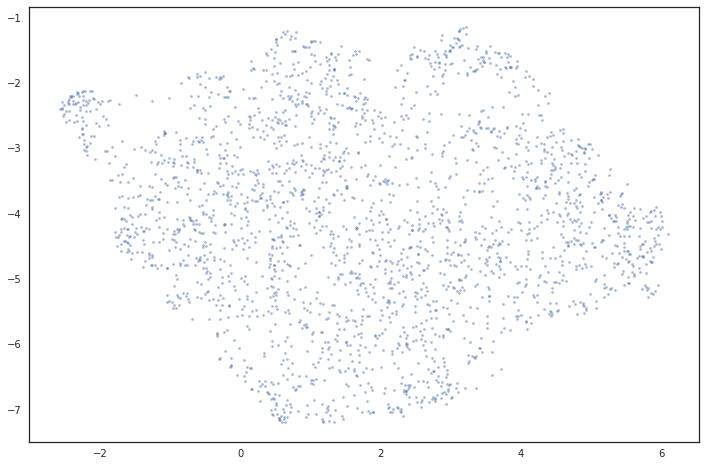

In [39]:
plot_scatter(mean_u)

### TensorBoard Embedding Projectorへ

In [56]:
import pandas as pd
limit = 5000
df = pd.DataFrame(ptbs.src.data).T
test_label_list = [ids2text(target, vocab.text.i2w) for target in df.target.tolist()]
from torch.utils.tensorboard import SummaryWriter
save_dir = f'{runs_dir}/{model_name}/posvae_eccos_v2_embeddings'
print(save_dir)
writer = SummaryWriter(save_dir)
writer.add_embedding(torch.FloatTensor(encoded_mean_arr[:limit]), metadata=test_label_list[:limit])

/root/user/work/src/Sentence-VAE/runs/posvae_eccos_v2_TS=2020-01-05-173701_BS=32_LR=0.001_EB=300_GRU_HS=256_L=1_BI=0_LS=16_WD=0_ANN=LOGISTIC_K=0.0025_X0=2500/posvae_eccos_v2_embeddings
